In [1]:
from tomoSegmentPipeline.showcaseResults import (predict_fullTomogram, load_model, load_tomoData, Tversky_index,
                                        fullTomogram_modelComparison, make_comparison_plot, write_comparison_gif, save_classPred)

from tomoSegmentPipeline.losses import Tversky_loss
from tomoSegmentPipeline.utils.common import read_array, write_array
import tomoSegmentPipeline.dataloader as dl
from tomoSegmentPipeline.utils import setup
from tomoSegmentPipeline.dataloader import to_categorical, transpose_to_channels_first
from tomoSegmentPipeline.trainWrapper import make_trainer

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = PARENT_PATH+'data/isoNet/'

import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd
import torch
import os
from glob import glob

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# Normalize raw tomograms

In [2]:
raw_tomo_path = os.path.join(ISONET_PATH, 'salmonella_dataset/salmonella_minicells/')

training_tomos = ['20200213_GW214_tgt4_ali.rec', '20200213_GW214_tgt5_ali.rec']

for tomo in sorted(training_tomos):
    print('reading raw...')
    full_path = os.path.join(raw_tomo_path, tomo)
    raw_data = read_array(full_path)
    raw_data = (raw_data-raw_data.mean())/raw_data.std()
    raw_data = raw_data.astype(np.float32)
    # write_array(raw_data, full_path)
    write_array(raw_data, full_path.replace('rec', 'mrc'))
    
raw_data = read_array(full_path)
raw_data.mean(), raw_data.std()

reading raw...
reading raw...


(3.031726e-09, 1.0000001)

(array([5.90000000e+01, 7.04000000e+02, 4.49700000e+03, 6.63900000e+03,
        8.62500000e+03, 1.51197000e+05, 5.57098116e+08, 1.06990000e+05,
        6.31700000e+03, 5.36000000e+02]),
 array([-61.096302 , -51.747997 , -42.399693 , -33.05139  , -23.703087 ,
        -14.354782 ,  -5.0064783,   4.341826 ,  13.69013  ,  23.038433 ,
         32.386738 ], dtype=float32),
 <BarContainer object of 10 artists>)

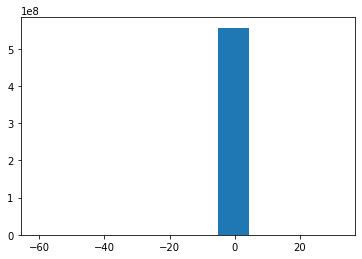

In [4]:
plt.hist(raw_data.flatten())

(array([7.45846600e+06, 1.31806300e+07, 3.38214410e+07, 7.23660210e+07,
        1.14317893e+08, 1.30128233e+08, 1.00211735e+08, 5.39729430e+07,
        2.19979300e+07, 9.92838800e+06]),
 array([-2.8618803 , -2.3169549 , -1.7720294 , -1.2271041 , -0.6821786 ,
        -0.13725317,  0.40767226,  0.9525977 ,  1.4975231 ,  2.0424485 ,
         2.587374  ], dtype=float32),
 <BarContainer object of 10 artists>)

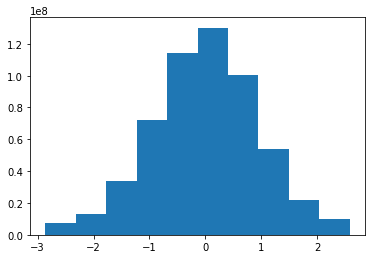

In [12]:
aux = np.clip(raw_data, np.quantile(raw_data, 0.005), np.quantile(raw_data, 0.995))
plt.hist(aux.flatten())

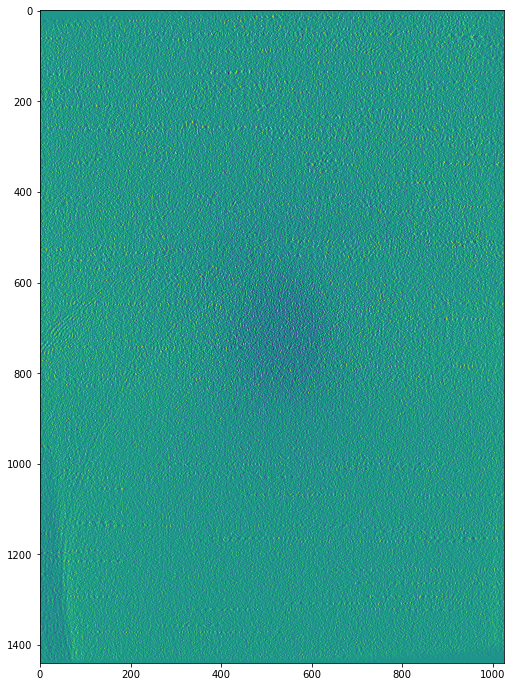

In [13]:
plt.figure(figsize=(10, 12))
plt.imshow(aux[80])

# Deconvolved tomograms to mrc file

In [2]:
convolved_path = os.path.join(ISONET_PATH, 'salmonella_dataset/tomos_deconv/')

training_tomos = ['20200213_GW214_tgt4_ali.rec', '20200213_GW214_tgt5_ali.rec']

for tomo in sorted(training_tomos):
    print('reading CTF deconvolved data...')
    full_path = os.path.join(convolved_path, tomo)
    data = read_array(full_path)
    data = data.astype(np.float32)
    write_array(data, full_path.replace('rec', 'mrc'))

reading CTF deconvolved data...
reading CTF deconvolved data...


# Inspect step outputs

reading raw...
reading deconv...
reading mask...
reading corrected...


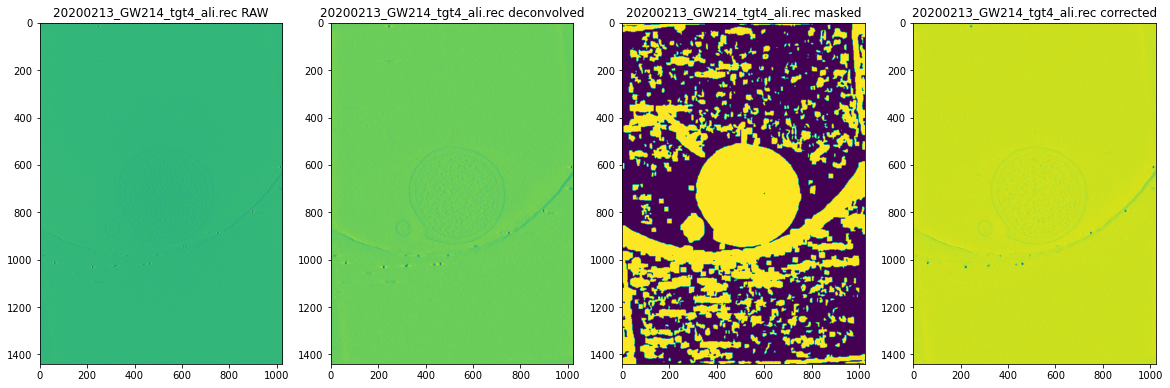

reading raw...
reading deconv...
reading mask...
reading corrected...


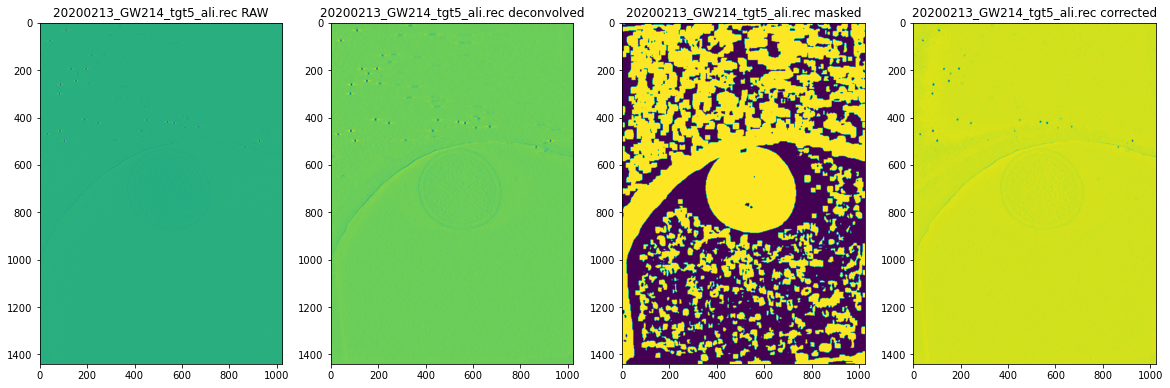

In [2]:
# --snrfalloff 1 --deconvstrength 1

raw_tomo_path = os.path.join(ISONET_PATH, 'salmonella_dataset/salmonella_minicells/')
deconv_tomo_path = os.path.join(ISONET_PATH, 'salmonella_dataset/tomos_deconv/')
mask_tomo_path = os.path.join(ISONET_PATH, 'salmonella_dataset/tomos_mask/')
corrected_tomo_path = os.path.join(ISONET_PATH, 'salmonella_dataset/corrected_i30/')

training_tomos = ['20200213_GW214_tgt4_ali.rec', '20200213_GW214_tgt5_ali.rec']

for tomo in sorted(training_tomos):
    print('reading raw...')
    raw_data = read_array(os.path.join(raw_tomo_path, tomo))
    
    print('reading deconv...')
    deconv_data = read_array(os.path.join(deconv_tomo_path, tomo))
    
    print('reading mask...')
    masked_data = read_array(os.path.join(mask_tomo_path, tomo[0:-4]+'_mask.mrc'))
    
    print('reading corrected...')
    corrected_data = read_array(os.path.join(corrected_tomo_path, tomo[0:-4]+'_corrected.mrc'))
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 15))
        
    z_idx = raw_data.shape[0]//2
    ax[0].imshow(raw_data[z_idx])
    ax[0].set_title(tomo + ' RAW')
    ax[1].imshow(deconv_data[z_idx])
    ax[1].set_title(tomo + ' deconvolved')
    ax[2].imshow(masked_data[z_idx])
    ax[2].set_title(tomo + ' masked')
    ax[3].imshow(corrected_data[z_idx])
    ax[3].set_title(tomo + ' corrected')
    
    plt.show()

In [4]:
corrected_data = (corrected_data-corrected_data.mean())/corrected_data.std()

In [6]:
corrected_data.mean()

-2.5128306e-06

In [1]:
corrected_data

NameError: name 'corrected_data' is not defined

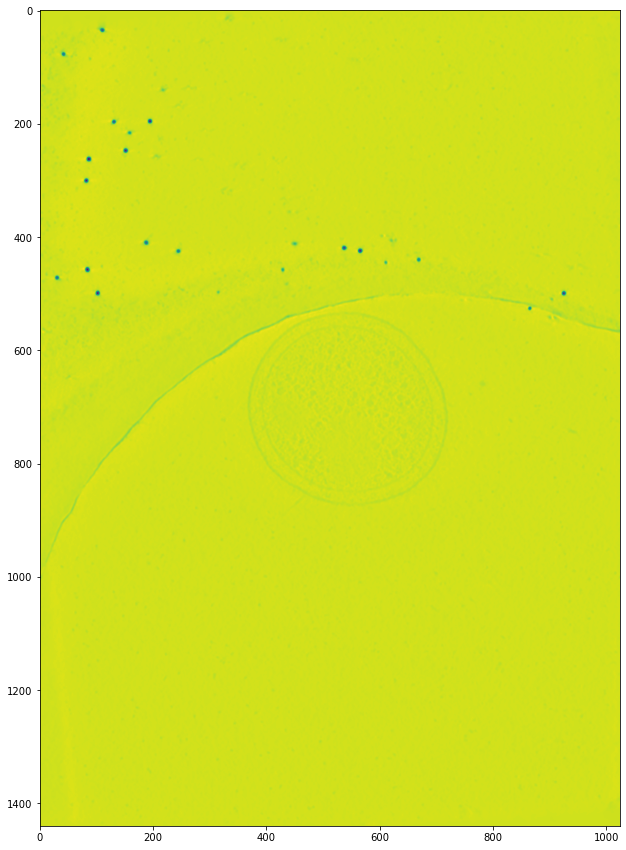

In [7]:
plt.figure(figsize=(12, 15))
plt.imshow(corrected_data[z_idx])